In [1]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt 
import copy 
%matplotlib inline 

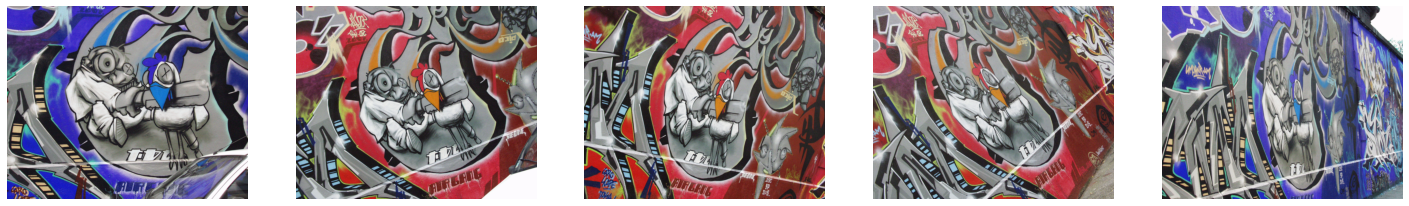

In [2]:
# --------------------- opening images (img1 to 5) ---------------------- 
img1 = cv.imread("graf/img1.ppm"); assert img1 is not None; img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB) 
img2 = cv.imread("graf/img2.ppm"); assert img2 is not None
img3 = cv.imread("graf/img3.ppm"); assert img3 is not None
img4 = cv.imread("graf/img4.ppm"); assert img4 is not None
img5 = cv.imread("graf/img5.ppm"); assert img5 is not None; img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB) 

fig, ax = plt.subplots(1, 5, figsize = (25, 5)) 
for i, im in enumerate((img1, img2, img3, img4, img5)):
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB) 
    ax[i].imshow(im); ax[i].axis('off') 

<font size='2'> 

#### **Question 3**
#### part (a) - Computing and Matching SIFT features 
* The targeted images `img1.ppm` and `img5.ppm` for which we have to find the homography have a large camera angle difference. Therefore, the keypoint matches given for this image pair by OpenCV `cv::BFMatcher::match` function mostly contain incorrect matches at a higher ratio, thus finding a homography directly from `img1` to `img5` is harder to carry out. 
* Therefore, here I have calculated the homography from `img1` to `img5` by taking the matrix multiplication of the homographies from `img4` to `img5` and `img1` to `img4`, where each of these image pairs contain a sufficient ratio of correct keypoint matches to find out a direct homography. 

In [3]:
# ======================== part (a) - Computing and Matching SIFT Features ========================= 
SIFT = cv.SIFT_create()             # initializing SIFT detector 
# extracting keypoints and SIFT descriptors for each image 
keys1, descriptors1 = SIFT.detectAndCompute(img1, None)
keys4, descriptors4 = SIFT.detectAndCompute(img4, None)
keys5, descriptors5 = SIFT.detectAndCompute(img5, None)

bf = cv.BFMatcher(crossCheck=True)  # initializing Brute Force Matcher for matching SIFT features   
matches1to4 = sorted(bf.match(descriptors1, descriptors4), key=lambda m: m.distance)
matches4to5 = sorted(bf.match(descriptors4, descriptors5), key=lambda m: m.distance) 

<font size="2"> 

#### Part (b) - Computing the Homography between two images using RANSAC algorithm 
- step 1 - randomly choose 4 matching keypoint pairs. [$s= 4$]
- step 2 - find the *corresponding homography* for those matches. (using Least Square algorithm)
- step 3 - finding the *Inlier* count of the estimated homography. 
> + For a keypoint pair (say, $kp1$ on *source/query* image to $kp2$ on *destination/train* image) to be considered as an inlier, the projection of $kp1$ onto the destination image under the estimated homography must reside within a given threshold distance $t$ from $kp2$. 
> + Since the size of the given Graffiti images are (640, 800) in pixels, a threshold distance of 5 pixels [i.e. a circular region around $kp2$ with diameter of 10 pixels] would be a suitable for estimating inliers. 
- step 4 - if there are more inliers than a given minimum threshold count ($d$), accept the estimation. 
> + We may set the minimum inlier count to be $50$% of the total number of the matching keypoint pairs. Thus, $d = 0.5 \times total \ number \ of \ matches $.  

Then, the minimum number of samples can be found using the following equation. Here, $ \ p = 0.99 \ (= 99$ % $), \ e \ {\small (outlier\ ratio)} = 0.5 \ {\small[for \ average \ case]} $. 

$ N = log(1-p) / log(1 - (1-e)^s) = log(1-0.99) / log(1 - (1-0.5)^4) = 71.36 \backsimeq 72 \ $ Sometimes, these numbers may be tuned to get a better result depending on the differences between the two images. 

Finally, the homography with the maximum inlier count is chosen as the **best estimation**, and the **final homography** is computed as the least-squre estimation of its inliers. If there are more than one such best estimations, then find the homography with the least average reprojection error regarding the inliers, where the reprojection error for a keypoint pair match $(kp1, kp2)$ is defined as $ \Vert kp2 - projectionUnderHomography(kp1) \Vert ^2 $.

In [14]:
# ======================== part (b) - Computing the Homography with RANSAC ========================= 
def reprojectionError(DMatch, keysQ, keysT, H): 
    "return the square of the distance between keypoint2 and the projection of keypoint1 under the specified homography"
    (x1, y1), (x2, y2) = keysQ[DMatch.queryIdx].pt, keysT[DMatch.trainIdx].pt # keypoint 1 (on image1) and keypoint 2 (on image2)
    X_2 = H @ np.array([x1, y1, 1]) 
    X_2 /= X_2[2]   # finding the homogeneous coordinate of projection of keypoint1 
    (xp, yp) = X_2[0], X_2[1] 
    reprojectionError = (xp-x2)**2 + (yp-y2)**2   # sqaure of distance between keypoint2 and the projection 
    return reprojectionError 

def avgReprojectionError(matches, keysQ, keysT, H): 
    "return the average reprojection error of a homography w.r.t. a given set of keypoint matches"
    sum = 0
    for Dmatch in matches: sum += reprojectionError(Dmatch, keysQ, keysT, H) 
    return (sum / len(matches)) 

def leastSquareHomography(matches, keysQ, keysT): 
    "computes the homography for a given set of keypoint matches using the Least Square method"
    if not len(matches) >= 4: print("Error - not enough matches to determine a homography") 
    A = np.zeros((1, 9)) # initialize a dummy array with all zeros D 
    for Dmatch in matches: 
        (x1, y1), (x2, y2) = keysQ[Dmatch.queryIdx].pt, keysT[Dmatch.trainIdx].pt 
        row1 = np.array([x1, y1,  1,  0,  0,  0, -x2*x1, -x2*y1, -x2]).astype(np.float64) 
        row2 = np.array([ 0,  0,  0, x1, y1,  1, -y2*x1, -y2*y1, -y2]).astype(np.float64) 
        A = np.vstack((A, row1)) 
        A = np.vstack((A, row2)) 
    A = A[1: ] # removing the dummy zero array from the top 
    # the homography Matrix H can be obtained from the eigen vector of (A.T @ A) that corresponds to the smallest eigen value. 
    evalues, evectors = np.linalg.eig(np.dot(A.T, A)) 
    i_min = min(range(len(evalues)), key = lambda i: evalues[i]) 
    h = evectors[:, i_min] 
    H = h.reshape((3, 3)) 
    return H 

def RANSACHomography(matches, keysQ, keysT, N, t, d): 
    "computes the homography for a given set of keypoint matches using the RANSAC algorithm"
    trial = 0; sampleIndices = []; candidateHomograhpies = [] 
    while trial < N: # perform N number of estimations  
        # ---------------------- step (1) - randomly choose 4 matching keypoint pairs ---------------------- 
        (i1, i2, i3, i4) = np.random.randint(0, len(matches), 4) # finding 4 random indices in 'matches' array 
        if (len(set((i1, i2, i3, i4))) < 4): N += 1; continue   # if the points in the sample are not distinct, then reject the sample 
        sortedIndices = list(np.sort([i1, i2, i3, i4])) 
        if sortedIndices in sampleIndices: N += 1; continue     # if the sample is a permutation of a previous sample, then reject the sample
        sampleIndices
        sample = np.array([matches[i1], matches[i2], matches[i3], matches[i4]]) 

        # ------------------------ step (2) - finding the corresponding homography ------------------------- 
        H = leastSquareHomography(sample, keysQ, keysT) 

        # -------------------------------- step (3) - finding the inliers ---------------------------------- 
        inlierMatches = [] 
        for match in matches: 
            if reprojectionError(match, keysQ, keysT, H) <= t**2: inlierMatches.append(match) 
        
        # ------------- step (4) - if there are 'd' or more inliers, then accept the estimation ------------ 
        if len(inlierMatches) >= int(len(matches) * d): candidateHomograhpies.append(inlierMatches) 
        trial += 1; 

    if len(candidateHomograhpies) == 0: print("No homographies found"); return [] 
    max_inlier_count = max([len(inlierMatches) for inlierMatches in candidateHomograhpies]) 
    best_estimations = [inlierMatches for inlierMatches in candidateHomograhpies if len(inlierMatches) == max_inlier_count] 
    if len(best_estimations) == 1: best_homography = leastSquareHomography(best_estimations[0], keysQ, keysT); print("no. of inlier matches", len(best_estimations[0]), ",  no. of total matches", len(matches))
    else: 
        minError = 10**100 # a fairly high value for the reference 
        for i, inlierMatches in enumerate(best_estimations): 
            H = leastSquareHomography(inlierMatches, keysQ, keysT) 
            error = avgReprojectionError(inlierMatches, keysQ, keysT, H) 
            if error < minError: minError = error; best_homography = H; I= i
        print("no. of inlier matches", len(best_estimations[I]), ",  no. of total matches", len(matches))
    return best_homography 

In [15]:
def comparingAndVisualizingH(H, filename): 
    file = open(filename, 'r') 
    data = np.zeros((3, 3))
    for i in range(3): 
        data[i] = np.array([eval(h) for h in (file.readline().split())]) 
    print("************* Computed Homography ************        ****** Homography given in \"H1to5p\" *****")
    for row1, row2 in zip(H, data): 
        print(row1, "      ", row2) 

In [16]:
def visualizingImg(nrows, ncols, imgs, titles, figsize_): 
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize_) 
    i = 0
    for row in range(nrows): 
        for col in range(ncols): 
            ax[i].imshow(imgs[i])
            ax[i].axis('off') 
            ax[i].set_title(titles[i]) 
            i += 1 

In [ ]:
def colorBlend(img1, img2, alpha = 0.5, beta = 0.5): 
    "blends only the non-zero regions of the given two images" 
    # creating a zero mask 
    mask = np.zeros(img2.shape[:2]) 

    # replacing color pixels in img2 by 1s in the mask 
    B1, G1, R1 = img1[:,:,0], img1[:,:,1], img1[:,:,2] # seperating the layers in img1 
    B2, G2, R2 = img2[:,:,0], img2[:,:,1], img2[:,:,2] # seperating the layers in img2 
    color1 = (B1 + G1 + R1).astype(bool) 
    color2 = (B2 + G2 + R2).astype(bool) 
    mask[(color1 & color2) != 0] = 1 
    mask = mask.astype(np.uint8) 

    # cutting img1 using the obtained mask 
    img1_ = copy.deepcopy(img1)
    B1, R1, G1 = img1_[:,:,0], img1_[:,:,1], img1_[:,:,2] 
    B1 *= mask; R1 *= mask; G1 *= mask 
    cutIn1 = cv.merge((B1, R1, G1)) 
    cutOut1 = img1 - cutIn1 

    # cutting img2 using the obtained mask 
    img2_ = copy.deepcopy(img2)
    B2, R2, G2 = img2_[:,:,0], img2_[:,:,1], img2_[:,:,2] 
    B2 *= mask; R2 *= mask; G2 *= mask 
    cutIn2 = cv.merge((B2, R2, G2)) 
    cutOut2 = img2 - cutIn2 

    # performing blending 
    blended = cutOut1 + cv.addWeighted(cutIn1, alpha, cutIn2, beta, 0.0) + cutOut2 
    return blended 

In [18]:
# ---------- finding the Homography and comparing with the homography given in the dataset ------ 
print("homography img1 to img4 :- ", end=" ")
H1to4 = RANSACHomography(matches1to4, keys1, keys4, N=8000, t=10, d=0.2) # *specifically tuned 
print("homography img4 to img5 :- ", end=" ")
H4to5 = RANSACHomography(matches4to5, keys4, keys5, N=200, t=3, d=0.5) 
print("homography img1 to img5 = ")
H1to5 = H4to5 @ H1to4   # finding the homography from img1 to img5 using our customized functions 
H1to5 /= H1to5[2][2]    # setting h33 element to be 1 

# comparing our result and the homography given in the text file 
comparingAndVisualizingH(H1to5, "graf/H1to5p") 

homography img1 to img4 :-  no. of inlier matches 197 ,  no. of total matches 889
homography img4 to img5 :-  no. of inlier matches 1052 ,  no. of total matches 1636
homography img1 to img5 = 
************* Computed Homography ************        ****** Homography given in "H1to5p" *****
[6.20546762e-01 6.17913552e-02 2.20569963e+02]        [6.2544644e-01 5.7759174e-02 2.2201217e+02]
[  0.21968548   1.14976975 -22.87220681]        [  0.22240536   1.1652147  -25.605611  ]
[ 4.84801106e-04 -5.50719702e-05  1.00000000e+00]        [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]


<font size="2"> 

* The first matrix (first column) shown above is the homography determined by the customized `RANSACHomography` function, and the second matrix is the pre-determined homography given in the `"H1to5p"` text file. 
* We can clearly observe that both the matrices are almost equal. 
#### part (c) - Visualizing the Results 

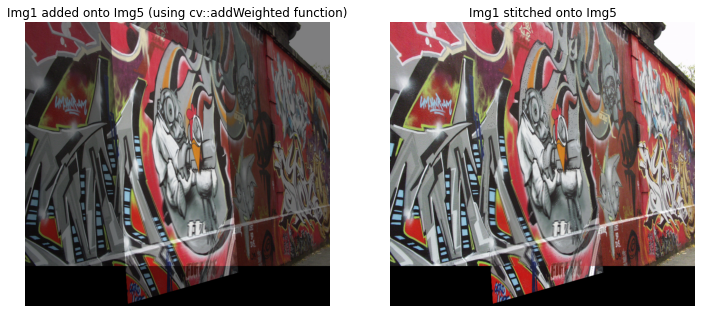

In [42]:
im1onto5 = cv.warpPerspective(img1,          H1to5, (800, 745)) # applying the computed homography on img1 
im5onto5 = cv.warpPerspective(img5, np.identity(3), (800, 745))  
addedImg = cv.addWeighted(im1onto5, 0.5, im5onto5, 0.5, 0)
stitchedImg = colorBlend(im1onto5, im5onto5)  

# ------------------------------------- visualizing the results ------------------------------------ 
# visualizingImg(1, 4, (im1onto5, im5onto5, addedImg, stitchedImg), ("Image 1 transformed", "Image 5", "using cv::addWeighted", "using a customized funtion"), (24, 10))
visualizingImg(1, 2, (addedImg, stitchedImg), ("Img1 added onto Img5 (using cv::addWeighted function)", "Img1 stitched onto Img5"), (12, 6)) 